# NMX Demo
In this example, we will use simulated data from McStas v.3.4.

This is simulated data on a crystal of Rubredoxin, a small protein, using the "standard" conditions for NMX. <br>
| Parameter | Value | Notes |
|-----------|-------|-------|
| `wavelength_range` ($\mathring A$) | 1.8 - 3.55 | The planned range for standard NMX experiments |
| `protein_name` | Rubredoxin | Associated Common protein name |
| `unit_cell` | $a$ = 33.9 Å, $b$ = 34.9 Å, $c$ = 43.5 Å <br>  $\alpha$ = $\beta$ = $\gamma$ = 90° | Unit cell of rubredoxin |
| `space_group` | $P2_{1}2_{1}2_{1}$ (19) | Space group of rubredoxin

## Build Pipeline (Collect Parameters and Providers)
Import the providers from ``load_mcstas_nexus`` to use the ``McStas`` simulation data workflow. <br>
``MaximumProbability`` can be manually provided to derive more realistic number of events. <br>
It is because ``weights`` are given as probability, not number of events in a McStas file. <br>

In [1]:
%matplotlib widget

import h5py
import sys
from ess.nmx.mcstas import McStasWorkflow
from ess.nmx.mcstas import executables
from ess.nmx.types import *
import numpy as np
import scipp as sc
import glob

from nmx_workflow.config import POOCH_DATA_DIR
from nmx_workflow.config import PROCESSED_DATA_DIR
from nmx_workflow.config import INTERIM_DATA_DIR



2025-03-24 13:14:07.240 | INFO     | nmx_workflow.config:<module>:11 - PROJ_ROOT path is: /Users/aaronfinke/nmx_workflow/nmx_workflow


# Setup Logging

In [2]:
import logging
from datetime import datetime

# Create a file handler to save the log with current date and time
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

log_filename = datetime.now().strftime("binning_%Y%m%d_%H%M%S.log")
file_handler = logging.FileHandler(INTERIM_DATA_DIR / 'binning.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)



In [3]:
datafile_paths = glob.glob(f"{POOCH_DATA_DIR}/*.h5")
datafile_paths

['/Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_truncated_phi10.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_truncated_phi20.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_truncated_phi30.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_truncated_phi40.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_truncated_phi0.h5']

In [4]:
wfs = [McStasWorkflow() for _ in range(len(datafile_paths))]
wfs

In [ ]:
chunk_size = 100_000_000
detector_ids = [0, 1, 2]
# result_list = []
output_paths = []
for wf, datafile in zip(wfs, datafile_paths):
    with h5py.File(datafile) as fp:
        # xtalphiX = float( fp['/entry1/simulation/Param/XtalPhiX'].asstr()[0] )
        xtalphiY = float( fp['/entry1/simulation/Param/XtalPhiY'].asstr()[0] )
        # xtalphiZ = float( fp['/entry1/simulation/Param/XtalPhiZ'].asstr()[0] )
    # wf[CrystalRotation] = sc.vector([xtalphiX,xtalphiY,xtalphiZ], unit='deg')
    output_file = PROCESSED_DATA_DIR / f"scipp_export_phi{xtalphiY:.0f}.h5"
    result = executables.reduction(
        input_file=datafile,
        output_file='test.h5',
        chunk_size=chunk_size,
        detector_ids=detector_ids,
        compression=False,
        logger=logger,
        wf=wf,
        toa_min_max_prob=(0.0722728,0.143074,1.85895e-06)
    )
    # result_list.append(results)
    output_paths.append(output_file)
logger.info('Binning complete.')    
    


2025-03-23 14:49:12,795 - __main__ - INFO - Metadata given: (0.0722728, 0.143074, 1.85895e-06)
2025-03-23 14:49:12,878 - __main__ - INFO - Exporting metadata into the output file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi10.h5
2025-03-23 14:49:15,767 - __main__ - INFO - [{1}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:18,487 - __main__ - INFO - [{2}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:21,215 - __main__ - INFO - [{3}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:24,082 - __main__ - INFO - [{4}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:27,090 - __main__ - INFO - [{5}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:31,143 - __main__ - INFO - [{6}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:34,490 - __main__ - INFO - [{7}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:38,030 - __main__ - INFO - [{8}/{14}] Processed chunk for {nD_Mantid_0}
2025-03-23 14:49:41,458 - __

## Build Workflow

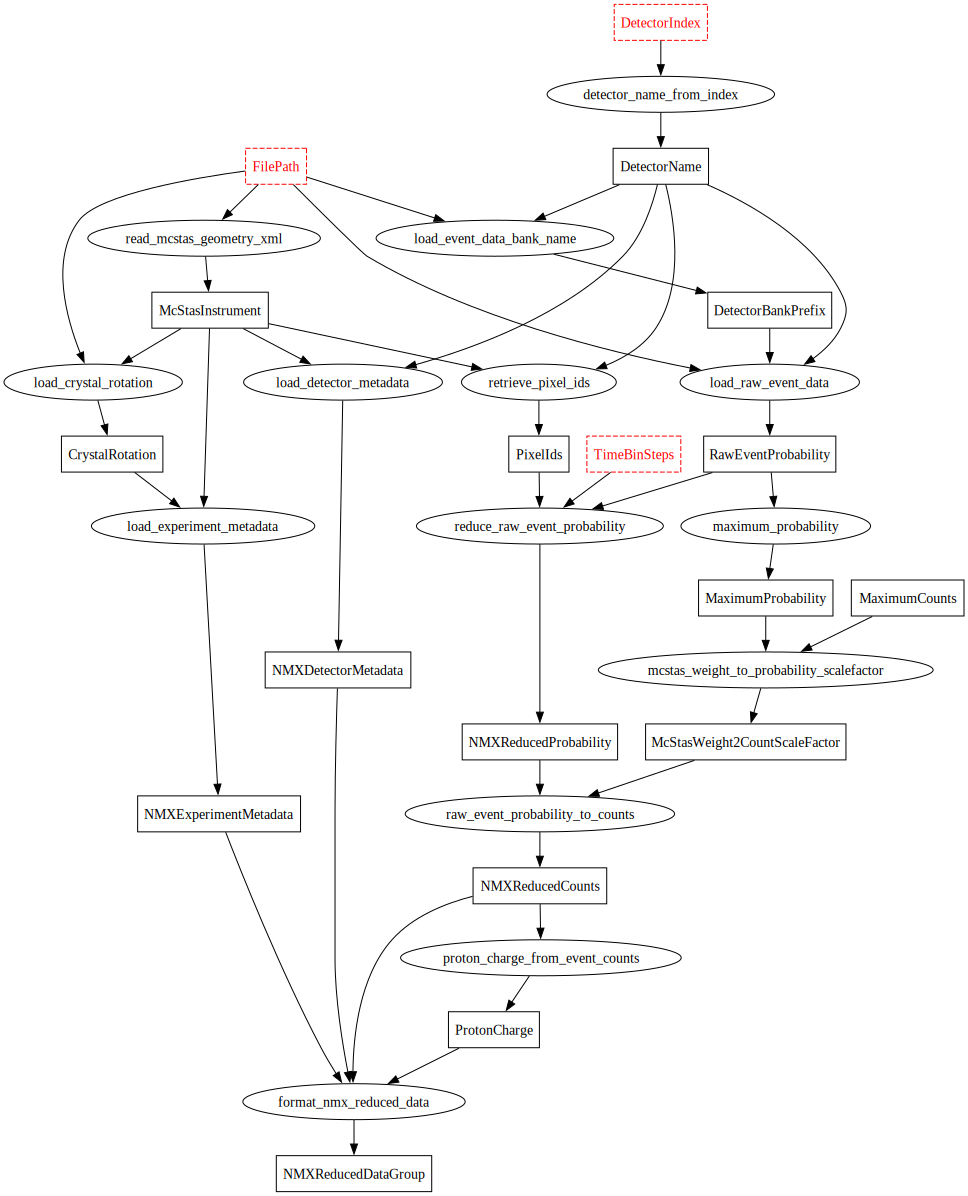

In [13]:
wfs[0].visualize(NMXReducedDataGroup, graph_attr={"rankdir": "TD"}, compact=True)

## Instrument View

Pixel positions are not used for later steps,
but it is included in the coordinates for instrument view.

All pixel positions are relative to the sample position,
therefore the sample is at (0, 0, 0).

In [9]:
import scippneutron as scn

da = result_list[3]["counts"]
da.coords["position"] = result_list[3]["position"]
# Plot one out of 100 pixels to reduce size of docs output
view = scn.instrument_view(da["id", ::5].sum('t'), norm="log", pixel_size=0.0075)
view

Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(…

In [2]:
output_paths = glob.glob(f"{PROCESSED_DATA_DIR}/scipp_export*")
output_paths

['/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi40.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi10.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi30.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi20.h5',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi0.h5']

The below is a quick workaround for current DIALS install, will be fixed in DIALS later.

## Data Reduction with DIALS

DIALS will be used for spotfinding, indexing, integration.

In [3]:
from libtbx.phil import parse

from dials.command_line import dials_import
from dials.command_line import find_spots
from dials.command_line import index
from dials.command_line import refine
from dials.command_line import tof_integrate

from dials.util import log

from dials.array_family.flex import reflection_table
from dxtbx.model.experiment_list import ExperimentListFactory

from libtbx.phil import parse
from pathlib import Path

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for dials::algorithms::profile_model::gaussian_rs::BBoxMultiCalculator already registered; second conversion method ignored.


In [4]:
dials_directory = PROCESSED_DATA_DIR / "dials"
dials_directory.mkdir(exist_ok=True)

## Importing Data into DIALS

DIALS uses PHIL (Python-based hierarchical interchange language), a JSON-like format for setting and organizing parameters for each processing module.

In [6]:
phil_scope = dials_import.phil_scope
format_phil = parse(f"""
output {{
    experiments = '{dials_directory}/imported.expt'
    log = '{dials_directory}/dials.import.log'
    compact = False
}}
""")
# working_phil = phil_scope.fetch(
#     sources = [format_phil])
# x = working_phil.format(python_object=None)
arg_hil = []
for x in format_phil.all_definitions():
    arg_hil.append(x.path + '=' + x.object.words[0].value)


In [7]:
log.config(verbosity=0,logfile=f"{dials_directory}/dials.import.log")
experiments = dials_import.do_import(args=[str(nexus_file) for nexus_file in output_paths] + arg_hil, phil=phil_scope, configure_logging=True);

100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


## Spot Finding

Spotfinding looks for spots on images separated by time bins.

In [8]:
findSpots = parse(f"""
output {{
    reflections = '{dials_directory}/strong.refl'
    log = '{dials_directory}/dials.find_spots.log'
}}
spotfinder {{
threshold {{
   dispersion {{
     gain = 0.0013
     kernel_size = 15 15
     sigma_background = 5
     sigma_strong = 3
     min_local = 2
	}}
     algorithm=radial_profile

}}
filter {{
   min_spot_size = 30
   max_spot_size = 9000

}}
}}
""")

working_phil = find_spots.working_phil

findSpots_phil = working_phil.fetch(
    sources=[findSpots])

findSpots_params = findSpots_phil.extract()

with open(dials_directory/'find_spots.phil','w') as fp:
    findSpots_phil.show(out=fp)

In [9]:
log.config(verbosity=0,logfile=findSpots_params.output.log)
reflections = find_spots.do_spotfinding(experiments=experiments, params=findSpots_params)


## Indexing in DIALS

In [11]:
index_phil = index.phil_scope
unit_cell = [33.41,34.75,43.65,90,90,90]
space_group = 'P212121'

index_options = parse(
f"""output {{
    reflections = '{dials_directory}/indexed.refl'
    experiments = '{dials_directory}/indexed.expt'
    log = '{dials_directory}/dials.index.log'
}}

indexing {{
  known_symmetry {{
    space_group = "{space_group}"
    unit_cell = {",".join(str(x) for x in unit_cell)}
  }}
}}
""")

index_params = index_phil.fetch(
    sources=[index_options]).extract()

In [12]:
from dials.algorithms.indexing import DialsIndexError

log.config(verbosity=0, logfile=index_params.output.log)
try:
    indexed_experiments, indexed_reflections = index.index(
        experiments=experiments,
        reflections=[reflections],
        params=index_params)
except (DialsIndexError, ValueError) as e:
    logger.error(f"Error in indexing: {e}")
# log.info("Saving refined experiments to %s", index_params.output.experiments)
indexed_experiments.as_file(index_params.output.experiments)
# log.info("Saving refined reflections to %s", index_params.output.reflections)
indexed_reflections.as_file(filename=index_params.output.reflections)

## Refinement 
Refine the diffraction geometry against indexed reflections

In [13]:
refinement_phil = refine.phil_scope

refine_options = parse(
f"""
output {{
    experiments = {dials_directory}/refined.expt
    reflections = {dials_directory}/refined.refl
    log = {dials_directory}/dials.refine.log
}}
detector {{
    panels = hierarchical
}}
"""
)

refine_params = refinement_phil.fetch(
    sources=[refine_options]).extract()

In [14]:
log.config(verbosity=0, logfile=refine_params.output.log)
refined_experiments, refined_reflections, refiner, refine_history = refine.run_dials_refine(
    indexed_experiments, indexed_reflections, refine_params)
refined_reflections.as_msgpack_file(refine_params.output.reflections)
refined_experiments.as_file(refine_params.output.experiments)

## Integrating TOF Data

In [19]:
dmin = 1.05

integration_phil = tof_integrate.phil_scope

integration_options = parse(
f"""
output {{
    experiments = {dials_directory}/integrated_calc.expt
    reflections = {dials_directory}/integrated_calc.refl
    log = {dials_directory}/dials.tof_integrate.log
}}
integration_type = *observed calculated

calculated{{
    dmin = {dmin if dmin else 'none'}
}}
method = *summation seed_skewness profile1d
"""
)

integration_params = integration_phil.fetch(
    sources=[integration_options]).extract()

In [16]:
log.config(verbosity=0,logfile=f"{dials_directory}/dials.tof_integrate.log")
integrated_reflections = tof_integrate.run_integrate(integration_params,refined_experiments,refined_reflections)
integrated_reflections.as_msgpack_file(integration_params.output.reflections)
refined_experiments.as_file(integration_params.output.experiments)

dmin 1.0519039373466745
Getting shoebox data
Computing for experiment 0
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x31ce32a40>
Computing for experiment 1
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x31ce32730>
Computing for experiment 2
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x31ce330d0>
Computing for experiment 3
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x31ce32ea0>
Computing for experiment 4
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x31ce33060>


In [20]:
integration_params.method

'summation'